## **1.2 $\texttt{P-VAE Synth}$ testing**

Experiments regarding the $\texttt{P-VAE Synth}$.

In [1]:
#Git clone the ddsp_textures repo in the parent directory if you haven't already
import os
import subprocess

# Define the path where you want to clone the repository
repo_url = "https://github.com/cordutie/ddsp_textures.git"
clone_path = os.path.abspath(os.path.join('..', '..', 'ddsp_textures'))

# Check if the directory already exists
if not os.path.exists(clone_path):
    print(f"Cloning the repository to {clone_path}...")
    subprocess.run(["git", "clone", repo_url, clone_path])
    print("Repository cloned successfully.")
else:
    print(f"The repository already exists at {clone_path}.")

The repository already exists at /home/esteban/Desktop/ddsp_textures_thesis/ddsp_textures.


In [2]:
#Add the ddsp's parent directory to the Python path so that we can import the necessary modules
import sys

ddsp_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if ddsp_dir not in sys.path:
    sys.path.append(ddsp_dir)

In [3]:
# import modules
import ddsp_textures.signal_processors.synthesizers as sp
import ddsp_textures.auxiliar.time_stamps           as ts
import ddsp_textures.architectures.VAE              as VAE

# Extra packages
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import torch
import itertools

### Experiment 1: Time stamps generator

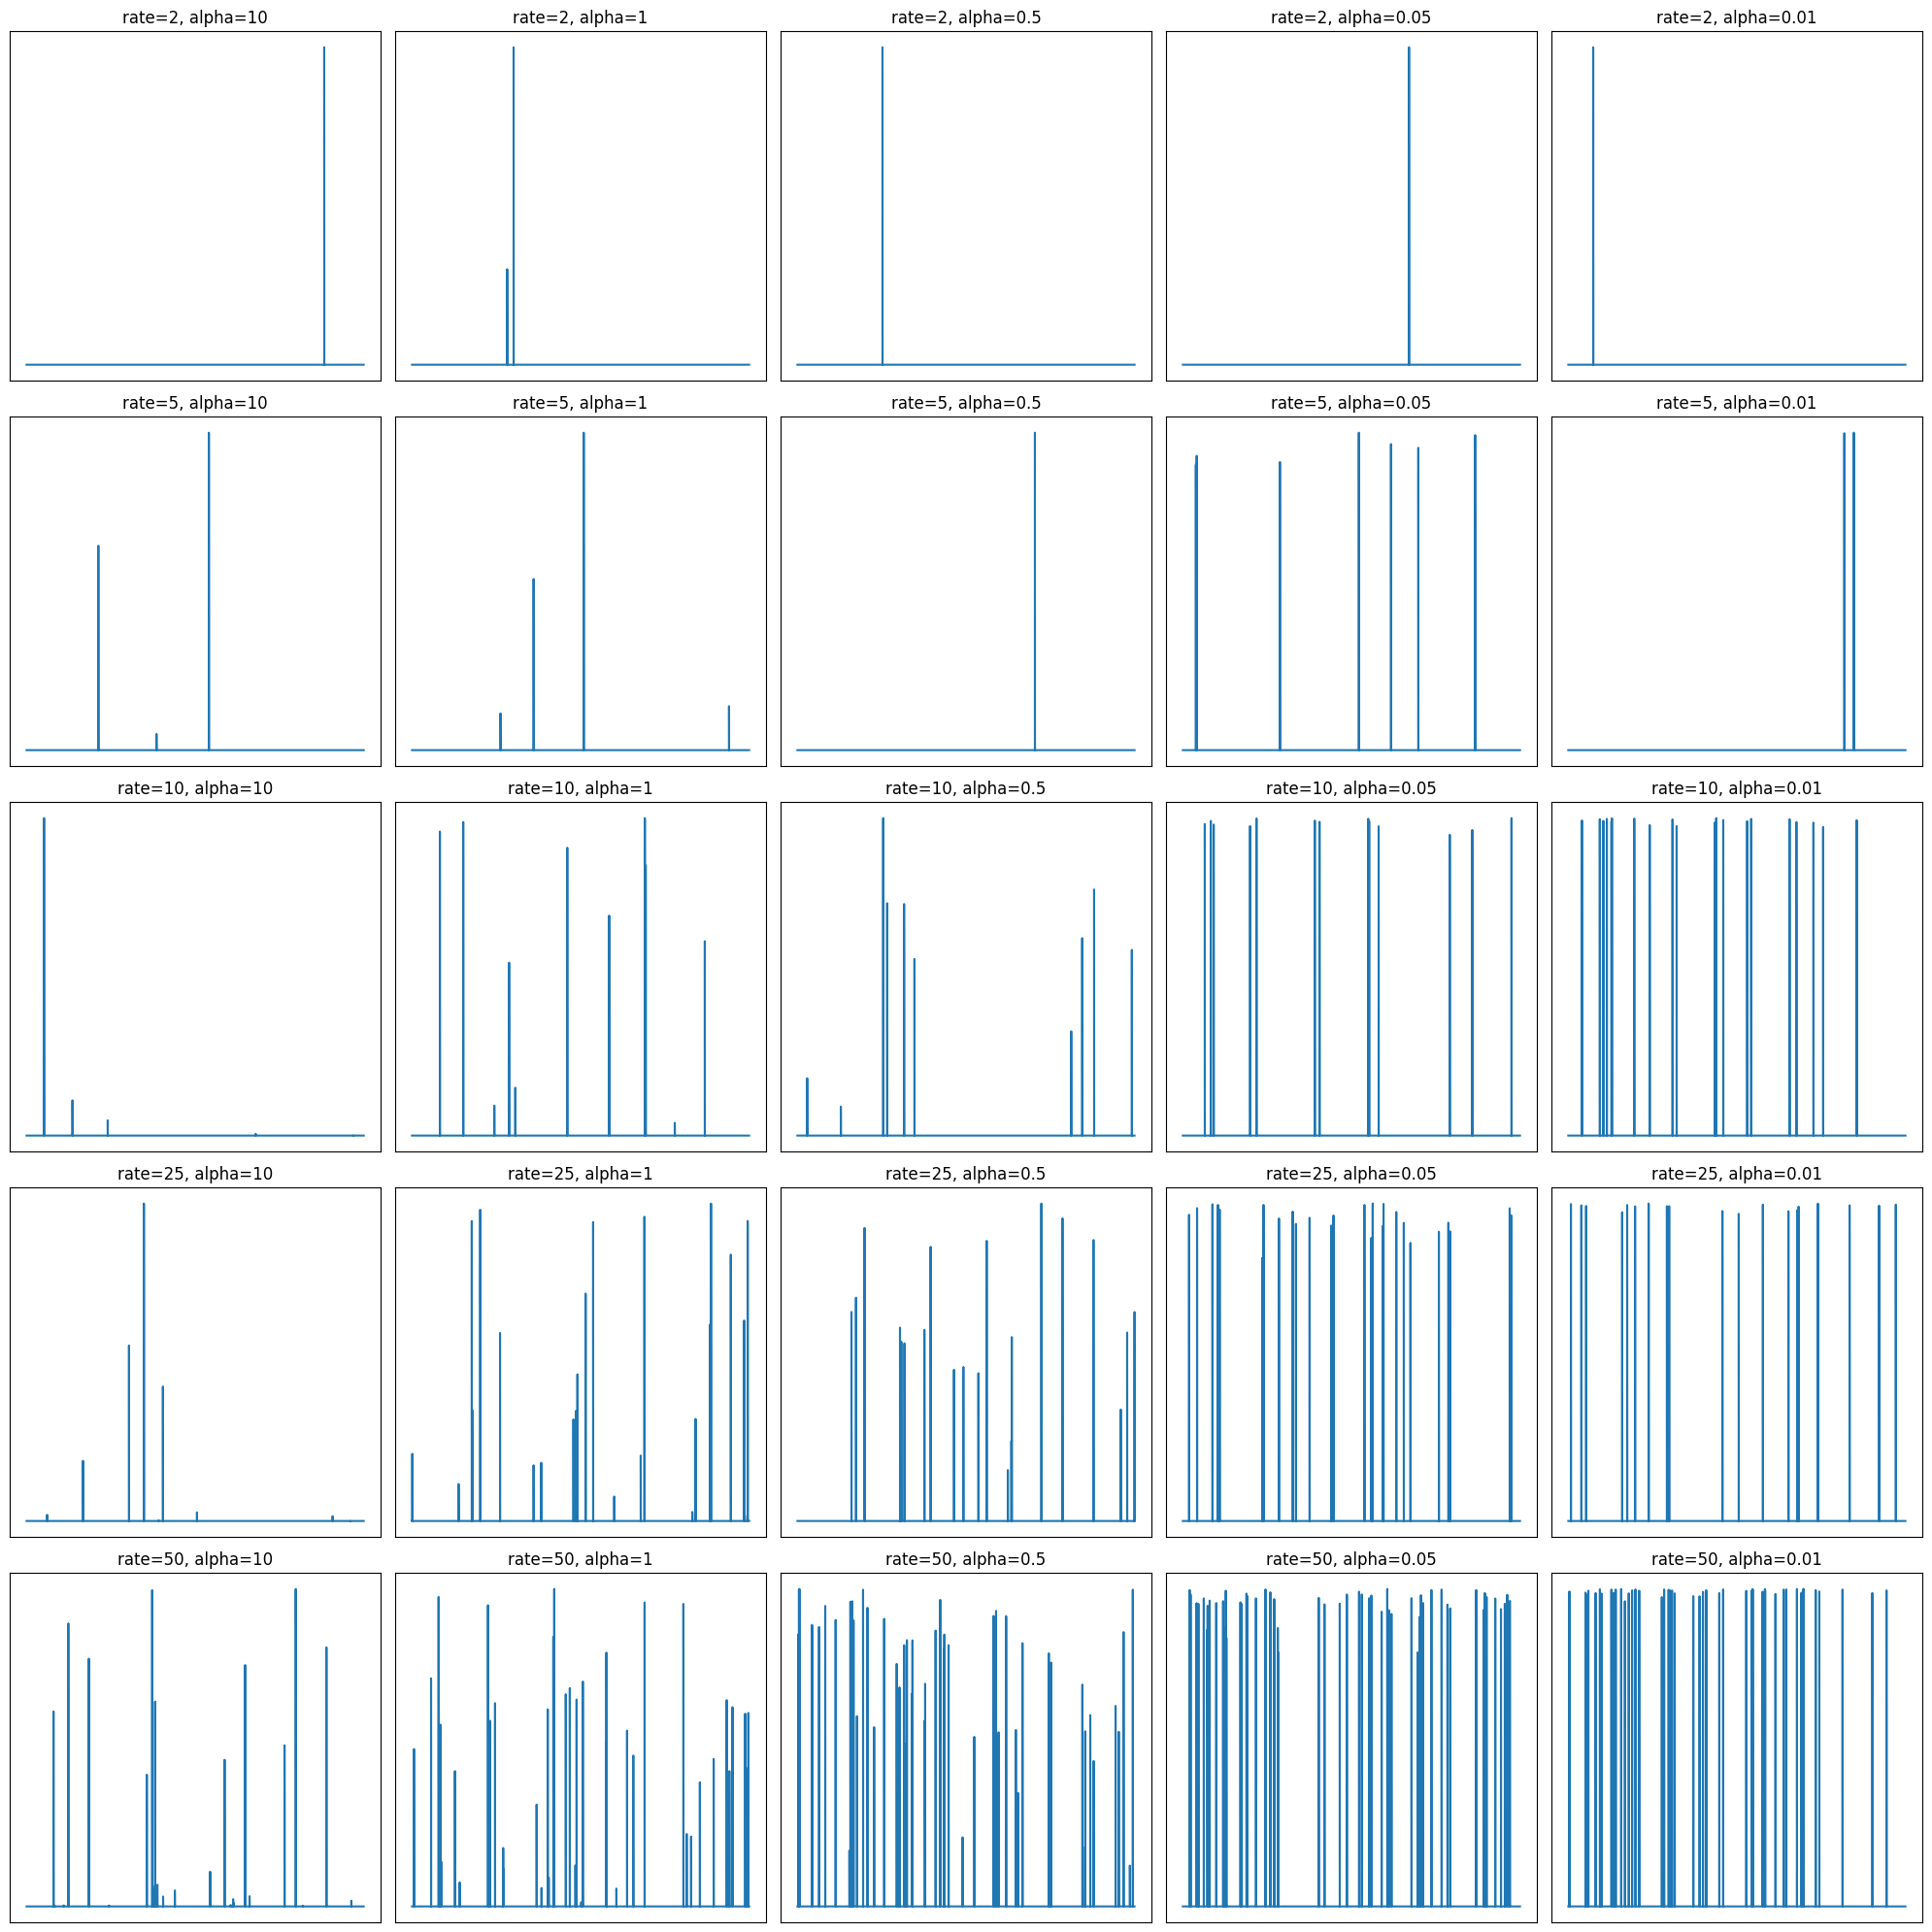

In [4]:
# Provided lists of parameters
rates = [2, 5, 10, 25, 50]
alphas = [10, 1, 0.5, 0.05, 0.01]

# Provided constants
sr = torch.tensor(44100.)  # standard sr
size = 44100  # 1 second

# Grid size
n_rows = len(rates)
n_cols = len(alphas)

# Create a figure and a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))

# Iterate over all combinations of rates and alphas
for i, (rate, alpha) in enumerate(itertools.product(rates, alphas)):
    row = i // n_cols
    col = i % n_cols

    # Generate the time_stamp tensor
    time_stamp = ts.time_stamps_generator(size, sr, rate, alpha)

    # Plot on the corresponding subplot
    axes[row, col].plot(time_stamp.numpy())
    axes[row, col].set_title(f'rate={rate}, alpha={alpha}')
    axes[row, col].set_xticks([])
    axes[row, col].set_yticks([])

# Adjust the layout
plt.tight_layout()
plt.show()

In [5]:
def time_stamps_rate_tester(size_exp, rate, sr):
    results = []
    for i in range(size_exp):
        random_alpha = 1
        time_stamp = ts.time_stamps_generator(sr, sr, rate, random_alpha)
        time_stamps_relued = torch.heaviside(time_stamp, torch.tensor([0.]))
        suma = torch.sum(time_stamps_relued)
        results.append(suma)
    #compute statistics of the results
    results = torch.tensor(results)
    mean = torch.mean(results)
    std = torch.std(results)
    #print
    print(f"Mean: {mean}")
    print(f"Std: {std}")
    return mean, std

size_exp = 1000
rate = 255.26
sr = 44100
time_stamps_rate_tester(size_exp, rate, sr)
    

Mean: 255.4739990234375
Std: 16.46518898010254


(tensor(255.4740), tensor(16.4652))

### Extra: Density of probability for atoms amplitude.

/tmp/ipykernel_1678391/2009939348.py:4: RuntimeWarning: divide by zero encountered in power
  return (1/alpha) * np.power(x,((1-alpha)/alpha))


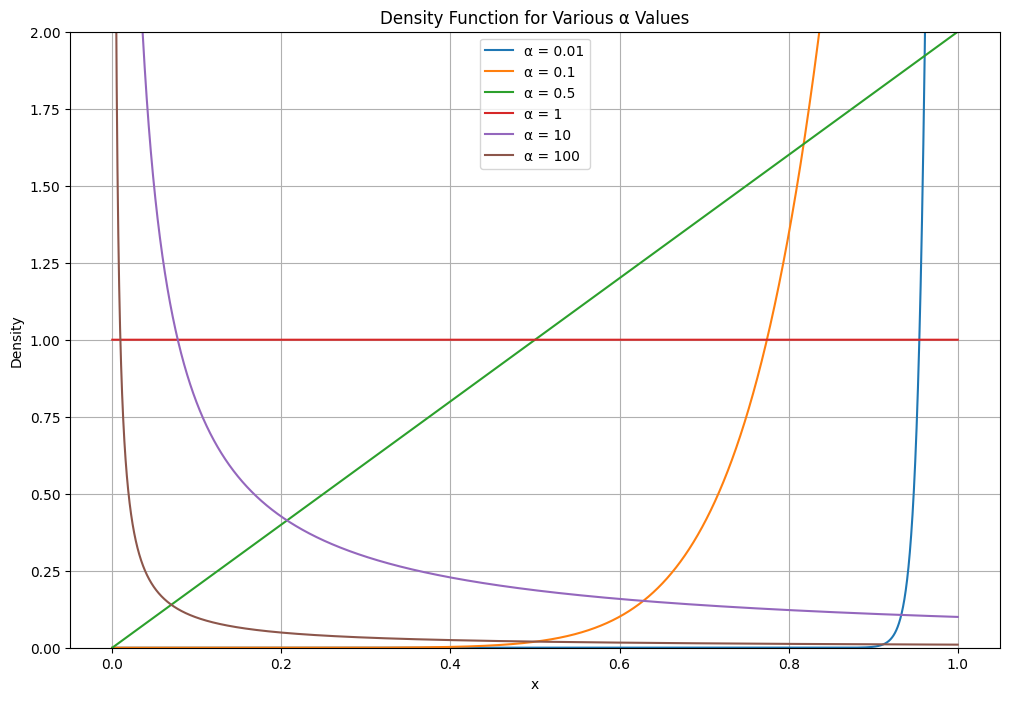

In [6]:
# Distribution of amplitudes 

def density(x, alpha):
    return (1/alpha) * np.power(x,((1-alpha)/alpha))    

# Values for alpha
alpha_values = [0.01, 0.1, 0.5, 1, 10, 100]

# Plotting the density functions
x = np.linspace(0, 1, 10000)
plt.figure(figsize=(12, 8))

for alpha in alpha_values:
    plt.plot(x, density(x, alpha), label=f'α = {alpha}')

plt.xlabel('x')
plt.ylabel('Density')
plt.ylim(0, 2)
plt.title('Density Function for Various α Values')
plt.legend()
plt.grid(True)
# plt.savefig('density_functions.png')
plt.show()

### Experiment 2: Atom generation through a VAE + the SubEnv Synth

In order to train a VAE to be used as an atom generator we used the repo VAE_SubEnv. The following is an example of how to run the trainer, however the training was actually run in the HPC cluster of the Universitat Pompeu Fabra.

In [7]:
#Git clone the VAE_SubEnv repo in the parent directory if you haven't already
import os
import subprocess

# Define the path where you want to clone the repository
repo_url = "https://github.com/cordutie/VAE_SubEnv.git"
clone_path = os.path.abspath(os.path.join('..', '..', 'VAE_SubEnv'))

# Check if the directory already exists
if not os.path.exists(clone_path):
    print(f"Cloning the repository to {clone_path}...")
    subprocess.run(["git", "clone", repo_url, clone_path])
    print("Repository cloned successfully.")
else:
    print(f"The repository already exists at {clone_path}.")

The repository already exists at /home/esteban/Desktop/ddsp_textures_thesis/VAE_SubEnv.


In [8]:
# import modules
from VAE_SubEnv.modules.dataset import *
from VAE_SubEnv.modules.seeds import *
from VAE_SubEnv.modules.architecture import *
from VAE_SubEnv.modules.trainer import *

import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

audio_path = '../data/sounds/water_augmented.wav'

frame_size, N_filter_bank, param_per_env = 17640, 24, 512
hidden_size, deepness = 512, 3
latent_dim = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sr = 44100
seed = seed_maker(frame_size, sr, N_filter_bank)
seed = seed.to(device)

settings = {
    'frame_size': frame_size,
    'hidden_size': hidden_size,
    'deepness': deepness,
    'latent_dim': latent_dim,
    'N_filter_bank': N_filter_bank,
    'param_per_env': param_per_env,
    }

#Dataset loading
dataset = VAE_Dataset(audio_path, frame_size, sr, N_filter_bank)
dataset_list = dataset.compute_dataset()
print("dataset size: ", len(dataset_list))
dataloader = DataLoader(dataset_list, batch_size=16, shuffle=True)

#Model loading
modelo = VAE_SubEnv(hidden_size, deepness, latent_dim, N_filter_bank, param_per_env, seed, device)

#Optimizer
optimizer = optim.Adam(modelo.parameters(), lr=1e-3)

#Training
model_path = '../data/VAE_SubEnv/watermodel/'
# train_statistics_loss(modelo, optimizer, 50, device, dataloader, model_path, N_filter_bank, frame_size, sr, settings)

/home/esteban/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


dataset size:  160


### Experiment 3: Latent Space exploration

Once the model is already trained, you can load it using the load_model function. Let's load the emodel and plot its latent space.

In [19]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from VAE_SubEnv.modules.dataset import *
from VAE_SubEnv.modules.seeds import *
from VAE_SubEnv.modules.architecture import *
from VAE_SubEnv.modules.trainer import *

# Display latent space
import torch
import numpy as np
from IPython.display import Audio, display, HTML

def display_latent_space(model, device, sr=44100):
    # Define the grid in the latent space
    grid_size = 5  # Adjust this for more/less granularity
    A = 2
    latents = np.linspace(-1 * A, A, grid_size)
    latent_grid = np.array([[x, y] for x in latents for y in latents])

    # Initialize an empty list to store the generated sounds
    generated_sounds = []

    # Generate sounds for each point in the latent space grid
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for latent_vector in latent_grid:
            latent_tensor = torch.tensor(latent_vector, dtype=torch.float32).to(device)
            # latent_tensor = latent_tensor.unsqueeze(0)  # Add batch dimension

            # Generate sound using the VAE's generate function
            generated_sound = model.generate(latent_tensor)

            # Store the generated sound in the list
            generated_sounds.append(generated_sound.cpu().numpy().flatten())  # Flatten to 1D array and move to CPU

    # Reshape the generated sounds into a matrix form
    generated_sounds_matrix = np.array(generated_sounds).reshape(grid_size, grid_size, -1)

    # Display the sounds in a grid layout
    grid_html = "<table>"
    for i in range(grid_size):
        grid_html += "<tr>"
        for j in range(grid_size):
            grid_html += "<td>"
            sound_html = f"Latent: ({latent_grid[i*grid_size+j][0]:.2f}, {latent_grid[i*grid_size+j][1]:.2f})"
            sound_html += "<br>"
            sound_html += Audio(generated_sounds_matrix[i, j, :], rate=sr)._repr_html_()
            grid_html += sound_html
            grid_html += "</td>"
        grid_html += "</tr>"
    grid_html += "</table>"

    display(HTML(grid_html))
    
import torch
import matplotlib.pyplot as plt

def display_latent_space_spectrograms(model, device, sr=44100, grid_size=5, A=2, nfft=1024, hop_length=512):
    freq_ticks = [62.5, 125, 250, 500, 1000, 2000, 4000, 8000, 16000]

    
    # Define the grid in the latent space
    latents = np.linspace(-1 * A, A, grid_size)
    latent_grid = np.array([[x, y] for x in latents for y in latents])

    # Initialize an empty list to store the generated sounds
    generated_sounds = []

    # Generate sounds for each point in the latent space grid
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for latent_vector in latent_grid:
            latent_tensor = torch.tensor(latent_vector, dtype=torch.float32).to(device)
            # latent_tensor = latent_tensor.unsqueeze(0)  # Add batch dimension

            # Generate sound using the VAE's generate function
            generated_sound = model.generate(latent_tensor)

            # Store the generated sound in the list
            generated_sounds.append(generated_sound.cpu().numpy().flatten())  # Flatten to 1D array and move to CPU

    # Reshape the generated sounds into a matrix form
    generated_sounds_matrix = np.array(generated_sounds).reshape(grid_size, grid_size, -1)

    # Create a large plot to contain all spectrograms
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(20, 20))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust space between subplots

    for i in range(grid_size):
        for j in range(grid_size):
            ax = axes[i, j]
            audio_signal = generated_sounds_matrix[i, j, :]

            # Create the spectrogram plot
            Pxx, freqs, bins, im = ax.specgram(audio_signal, NFFT=nfft, Fs=sr, noverlap=hop_length, window=np.hanning(nfft))
            ax.set_ylim(50, 16000)  # Cap the frequencies between 31.25 Hz and 16,000 Hz
            ax.set_yscale('log')  # Plot on a logarithmic scale
            ax.set_title(f'Latent: ({latent_grid[i*grid_size+j][0]:.2f}, {latent_grid[i*grid_size+j][1]:.2f})', fontsize=8)
            ax.set_yticks(freq_ticks, labels=[str(f) for f in freq_ticks])  # Set custom frequency ticks
            if i == grid_size - 1:
                ax.set_xlabel('Time [s]')
            if j == 0:
                ax.set_ylabel('Frequency [Hz]')

    # Add colorbar to the right of the last column
    cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # Adjust position and size as needed
    cbar = plt.colorbar(im, cax=cbar_ax)
    cbar.set_label('Intensity [dB]')

    plt.show()

# Usage example:
# display_latent_space_spectrograms(model, device)


Model loaded from ../data/models/VAE_SubEnv/water_statistics/best_model.pth


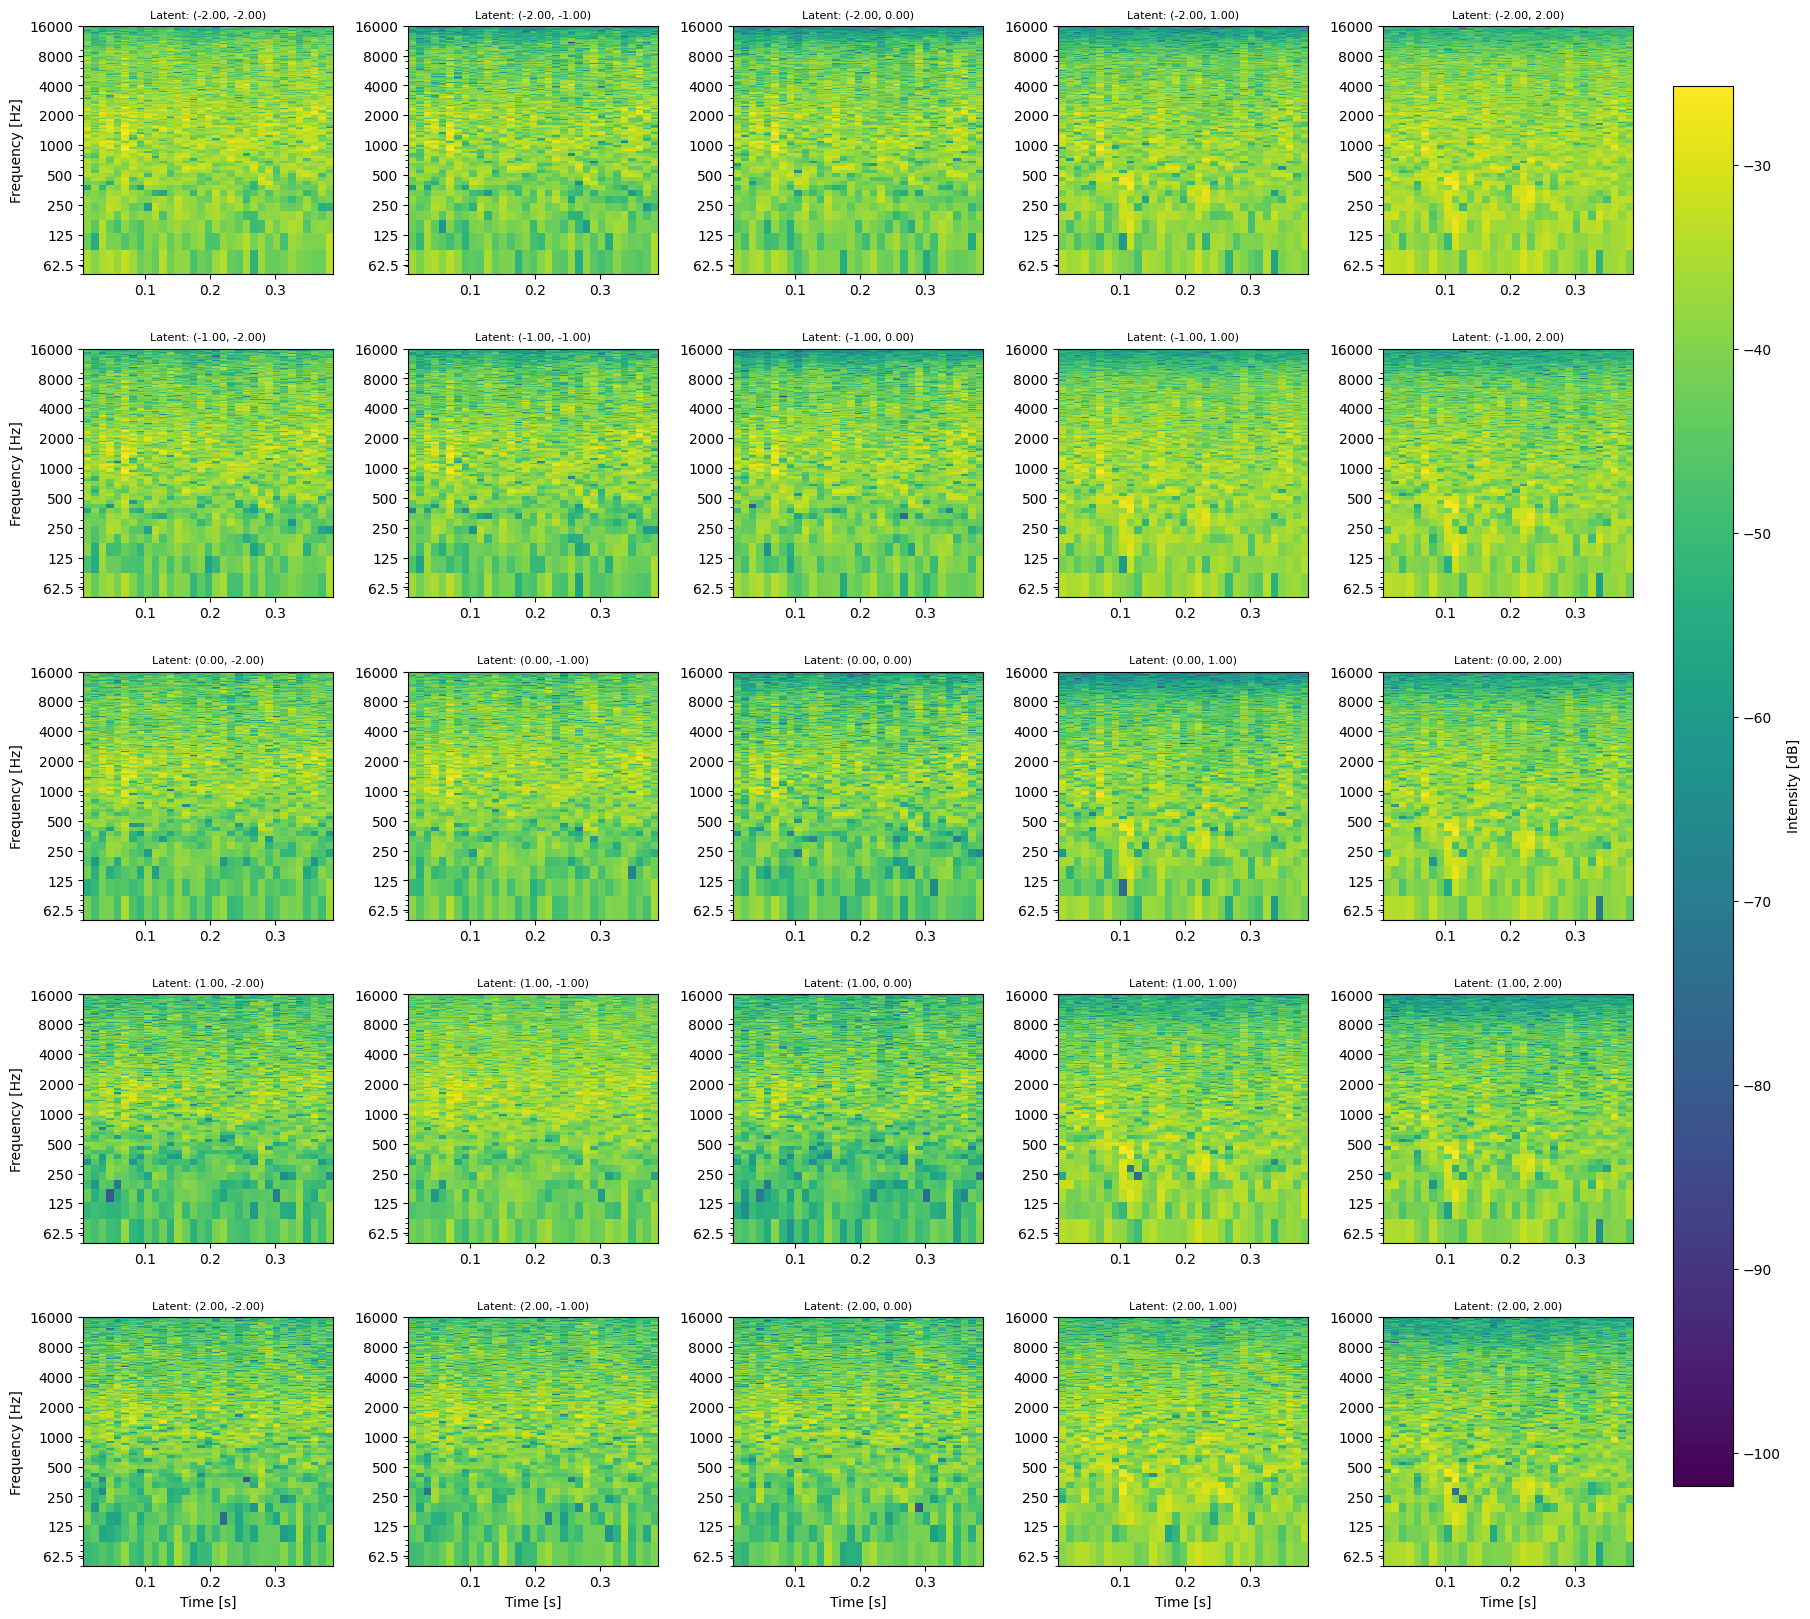

In [20]:
# Load the model parameters
model_path          = '../data/models/VAE_SubEnv/water_statistics/best_model.pth'
model_settings_path = '../data/models/VAE_SubEnv/water_statistics/best_model_settings.json'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model
model = load_model(model_path, model_settings_path, device)

#Display latent space
display_latent_space(model, device)
display_latent_space_spectrograms(model, device)

### Extra: delta * atom

torch.Size([61740])


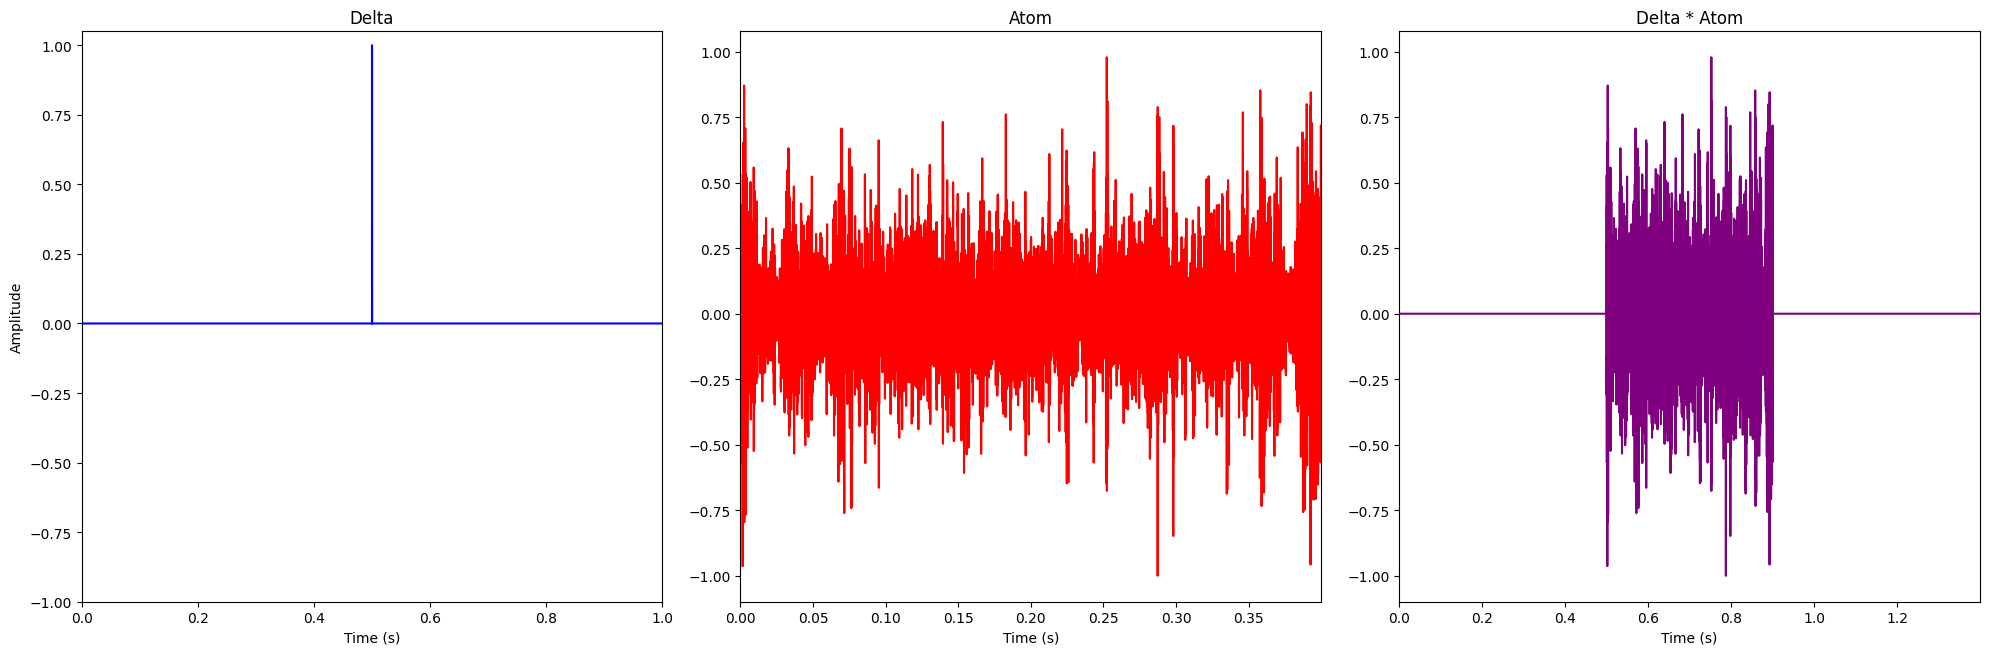

In [ ]:
from ddsp_textures.auxiliar.convolution import *

import matplotlib.pyplot as plt
import numpy as np
import torch
from IPython.display import Audio, display

sr = 44100

# Making a delta
E = torch.zeros(44100 + 1)
E[22050] = 1

# Atom generation
atom_encoded = torch.tensor([0, 0], dtype=torch.float32)
atom = model.generate(atom_encoded)  # Generate the atom
atom = atom / torch.max(torch.abs(atom))  # Normalize the atom

# Convolution
output = convolution_step(E, atom, 1)
print(output.size())

# Display audio
display(Audio(atom.detach().numpy(), rate=44100))
display(Audio(output.detach().numpy(), rate=44100))

# Convert tensors to numpy arrays for plotting
E_np = E.detach().numpy()
atom_np = atom.detach().numpy()
output_np = output.detach().numpy()

# Create a time vector in seconds
time_E = np.arange(len(E_np)) / sr
time_atom = np.arange(len(atom_np)) / sr
time_output = np.arange(len(output_np)) / sr

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(20, 6.66))

# Plot E
axs[0].plot(time_E, E_np, color='blue')
axs[0].set_title('Delta')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')
axs[0].set_xlim([time_E[0], time_E[-1]])
axs[0].set_yticks(np.arange(-1, 1.1, 0.25))

# Plot atom
axs[1].plot(time_atom, atom_np, color='red')
axs[1].set_title('Atom')
axs[1].set_xlabel('Time (s)')
axs[1].set_xlim([time_atom[0], time_atom[-1]])
axs[0].set_yticks(np.arange(-1, 1.1, 0.25))

# Plot output
axs[2].plot(time_output, output_np, color='purple')
axs[2].set_title('Delta * Atom')
axs[2].set_xlabel('Time (s)')
axs[2].set_xlim([time_output[0], time_output[-1]])
axs[0].set_yticks(np.arange(-1, 1.1, 0.25))

# Adjust layout
plt.tight_layout()
plt.show()


### Experiment 4: Exploratory Synthesis

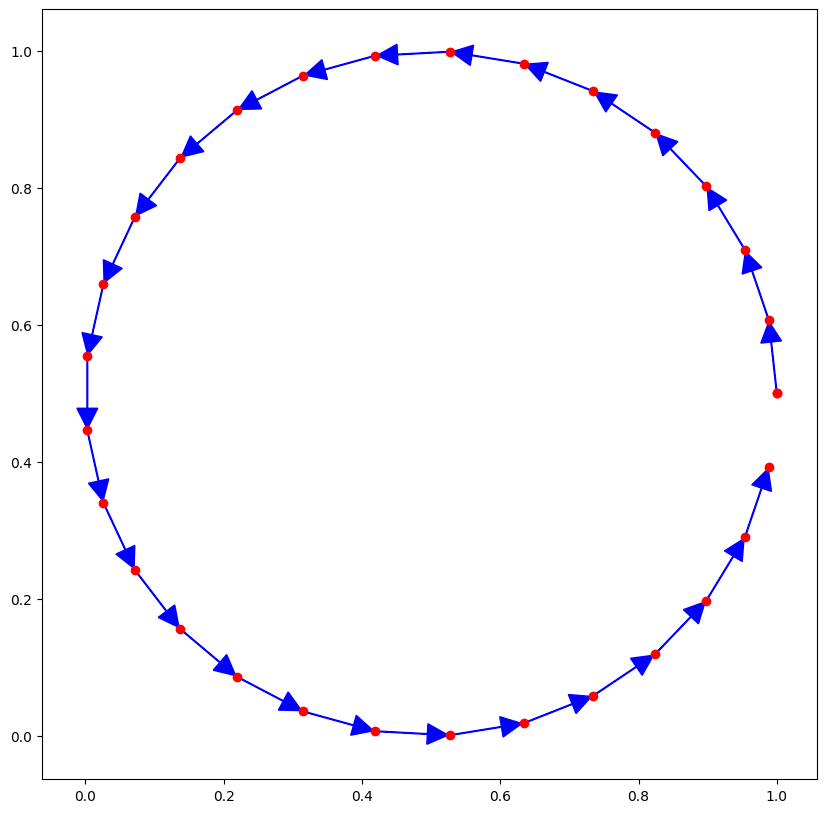

In [ ]:
from ddsp_textures.signal_processors.synthesizers import P_VAE, P_VAE_batches

K = 30             #number of atoms
latent_dim = 2     #from VAE model
# atom generation following a circle in the latent space
encoded_atoms = torch.zeros(2*K)
theta         = torch.linspace(0, 2*np.pi, K)
for i in range(K):
    encoded_atoms[i*2]   = 0.5*torch.cos(theta[i])+0.5
    encoded_atoms[i*2+1] = 0.5*torch.sin(theta[i])+0.5
#plot all the encoded atoms
scaler=0.7
plt.figure(figsize=(10, 10))  # Set width and height to 6 (or any equal value)
#plot short blue arrows between the encoded atoms
for i in range(K-2):
    plt.arrow(encoded_atoms[i*2].numpy(), encoded_atoms[i*2+1].numpy(), scaler*(encoded_atoms[(i+1)*2].numpy()-encoded_atoms[i*2].numpy()), scaler*(encoded_atoms[(i+1)*2+1].numpy()-encoded_atoms[i*2+1].numpy()), head_width=0.03, head_length=0.03, fc='blue', ec='blue')
plt.scatter(encoded_atoms[0:2*K:2].numpy(), encoded_atoms[1:2*K:2].numpy(), c='red', marker='o')
plt.show()
atoms_size = 17640 #from VAE model
model = model      #VAE model loaded
time_roughly = 10  #seconds
result = P_VAE(time_stamps_size=time_roughly*sr, lambda_rate=10, alpha=0.5, sr=sr, VAE = model, latent_dim=latent_dim ,atoms_size=atoms_size, encoded_atoms=encoded_atoms, atoms_new_size_factor=1).detach().numpy()
#reverse result
reversed_result = np.flip(result)
#play the result
display(Audio(reversed_result, rate=sr))

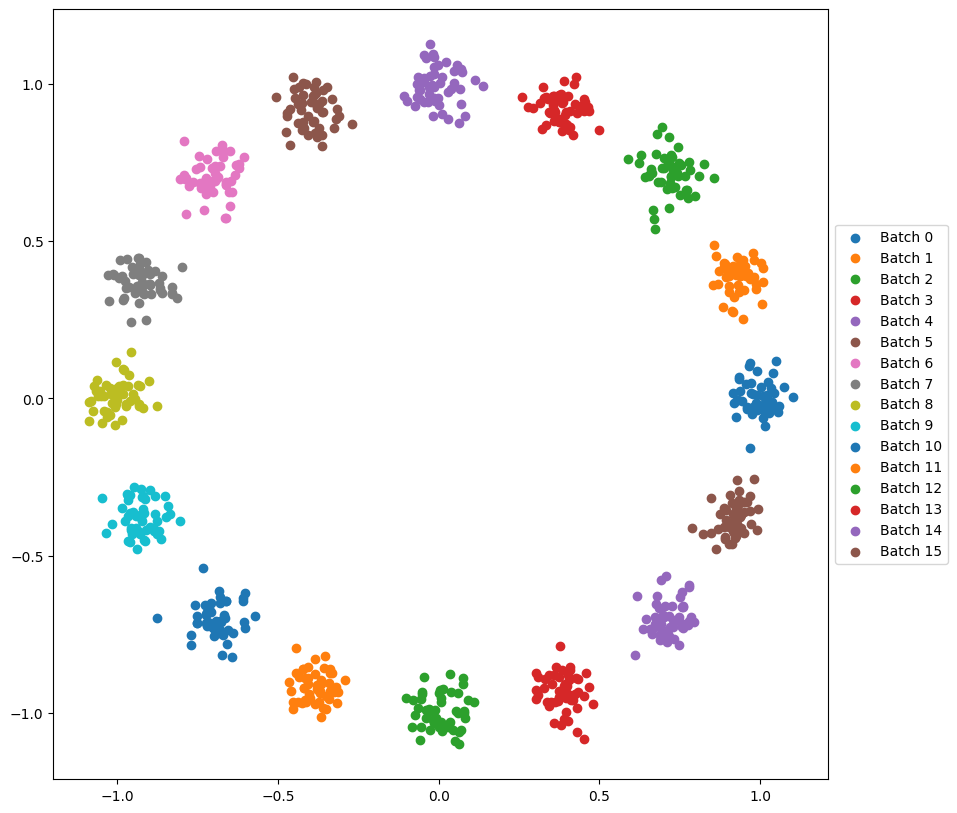

In [ ]:
batch_size = 16

K = 50
latent_dim = 2     #from VAE model
#make batch random of encoded atoms
encoded_atoms = torch.zeros(batch_size, 2*K)
theta = torch.linspace(0, 2*np.pi - (2*np.pi)/batch_size, batch_size)
for i in range(batch_size):
    for j in range(K):
        encoded_atoms[i, j*2]   = torch.cos(theta[i]) + torch.randn(1)*0.05
        encoded_atoms[i, j*2+1] = torch.sin(theta[i]) + torch.randn(1)*0.05
#plot all the encoded atoms
plt.figure(figsize=(10, 10))  # Set width and height to 6 (or any equal value)
for j in range(batch_size):
    plt.scatter(encoded_atoms[j, 0:2*K:2].numpy(), encoded_atoms[j, 1:2*K:2].numpy(),label=f'Batch {j}')
#plot legend on the side
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# batch of rates
lambda_rate_batch = torch.zeros(batch_size, 1)
for j in range(batch_size):
    lambda_rate_batch[j,0] = 10*(j+1)

alpha_batch = torch.ones(batch_size, 1)*0.5

atoms_size = 17640 #from VAE model
model = model      #VAE model loaded
time_roughly = 2  #seconds
result = P_VAE_batches(time_stamps_size=time_roughly*sr, lambda_rate=lambda_rate_batch, alpha=alpha_batch, sr=sr, VAE = model, latent_dim=latent_dim ,atoms_size=atoms_size, encoded_atoms=encoded_atoms, atoms_new_size_factor=0.125)
# #Display Audio
# display(Audio(result, rate=sr))

torch.Size([16, 90404])


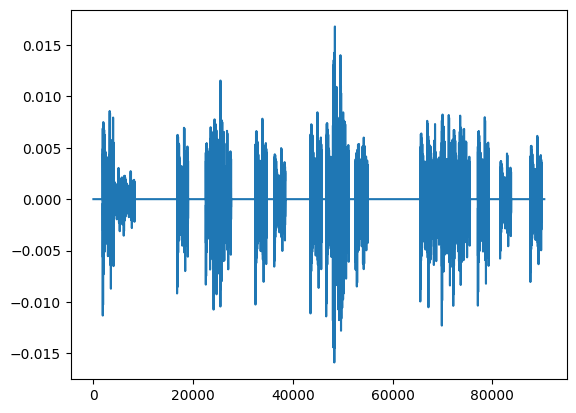

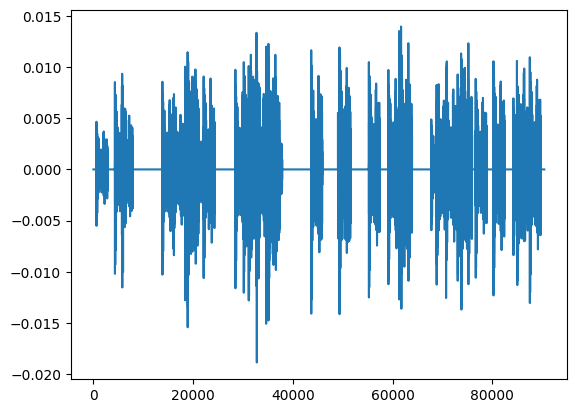

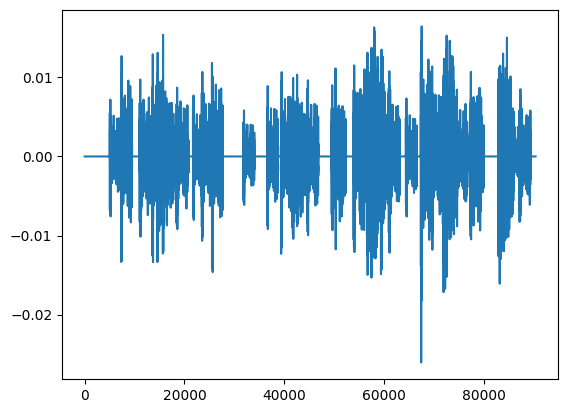

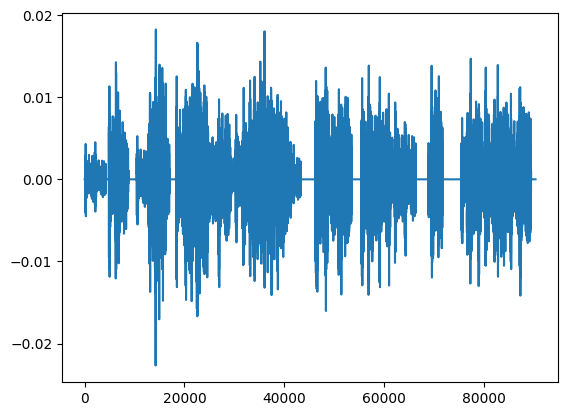

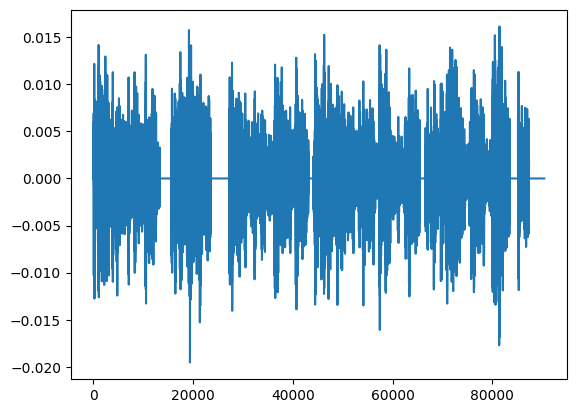

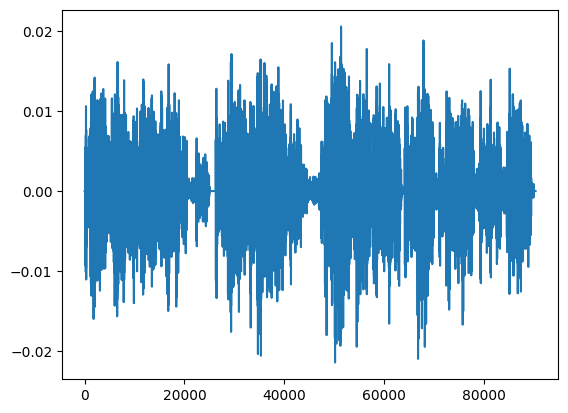

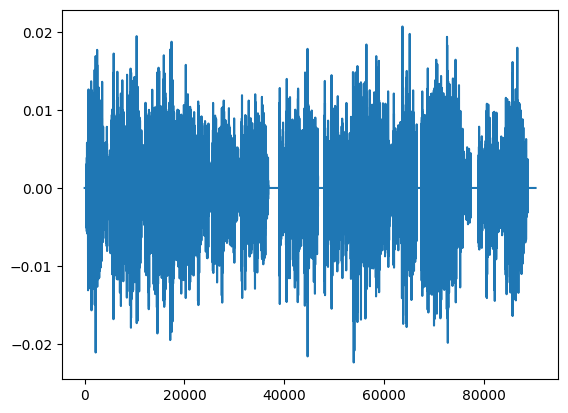

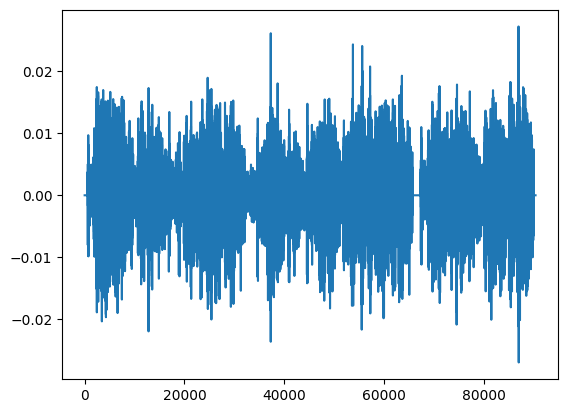

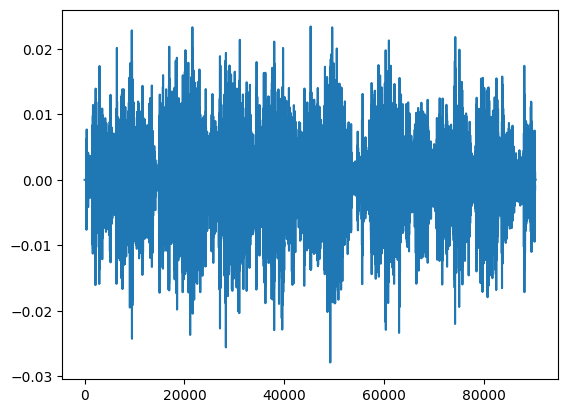

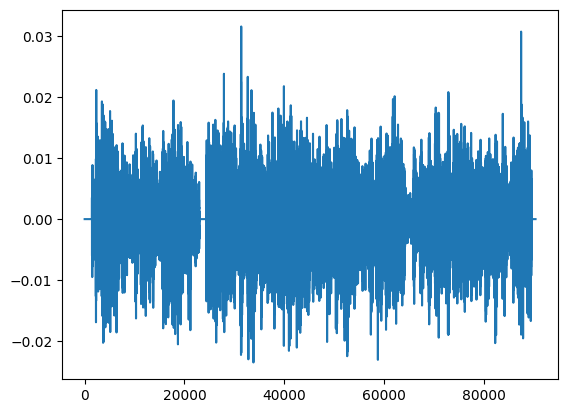

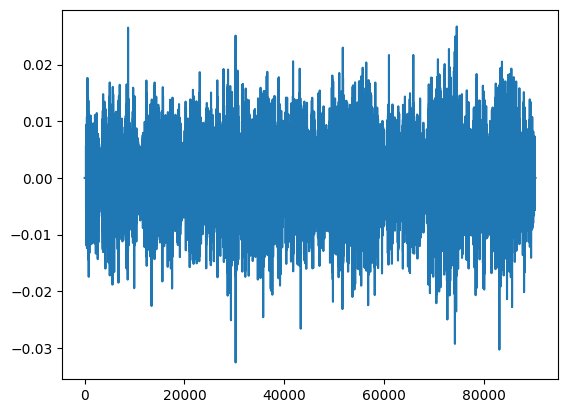

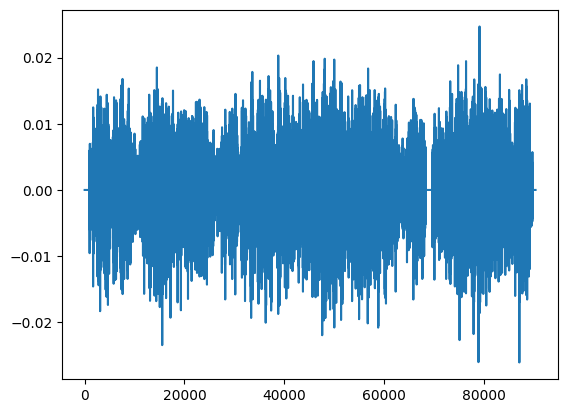

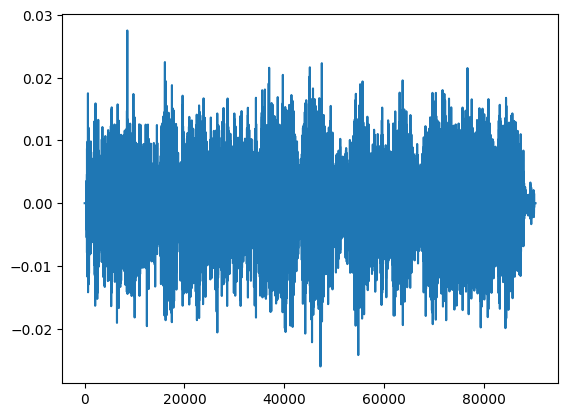

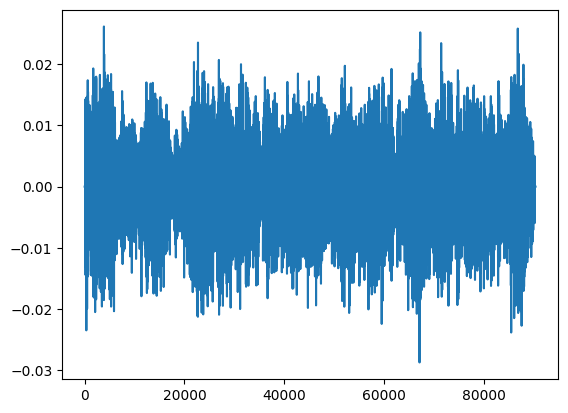

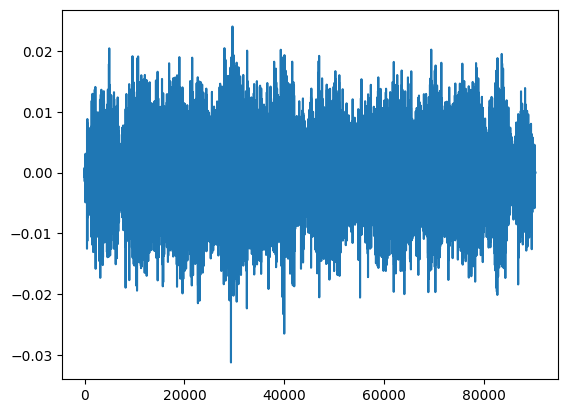

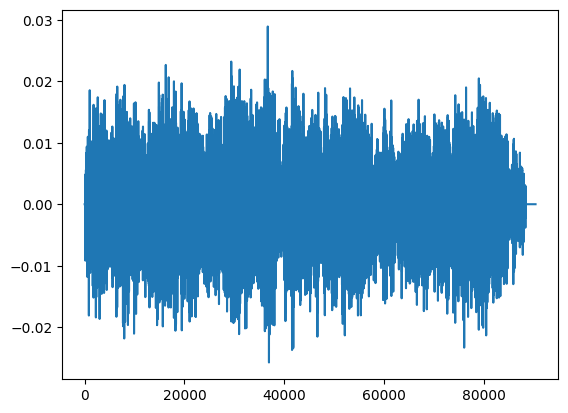

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display

print(result.size())
for j in range(batch_size):
    audio = result[j, :]
    audio_numpy = audio.detach().numpy()
    
    # Check and handle NaN or Inf values
    if np.isnan(audio_numpy).any() or np.isinf(audio_numpy).any():
        print(f"Warning: Audio contains NaN or Inf values in batch {j}. Replacing with zeros.")
        audio_numpy = np.nan_to_num(audio_numpy)
    
    # Normalize audio to prevent out-of-range values
    audio_numpy = np.clip(audio_numpy, -1, 1)
    
    # Plot audio
    plt.plot(audio_numpy)
    plt.show()
    
    # Display audio
    display(Audio(audio_numpy, rate=sr))